# Multi-Output Image Classification

## Project Goal
To develop a multi-output image classifier.

## Dataset
https://www.kaggle.com/kwentar/blur-dataset

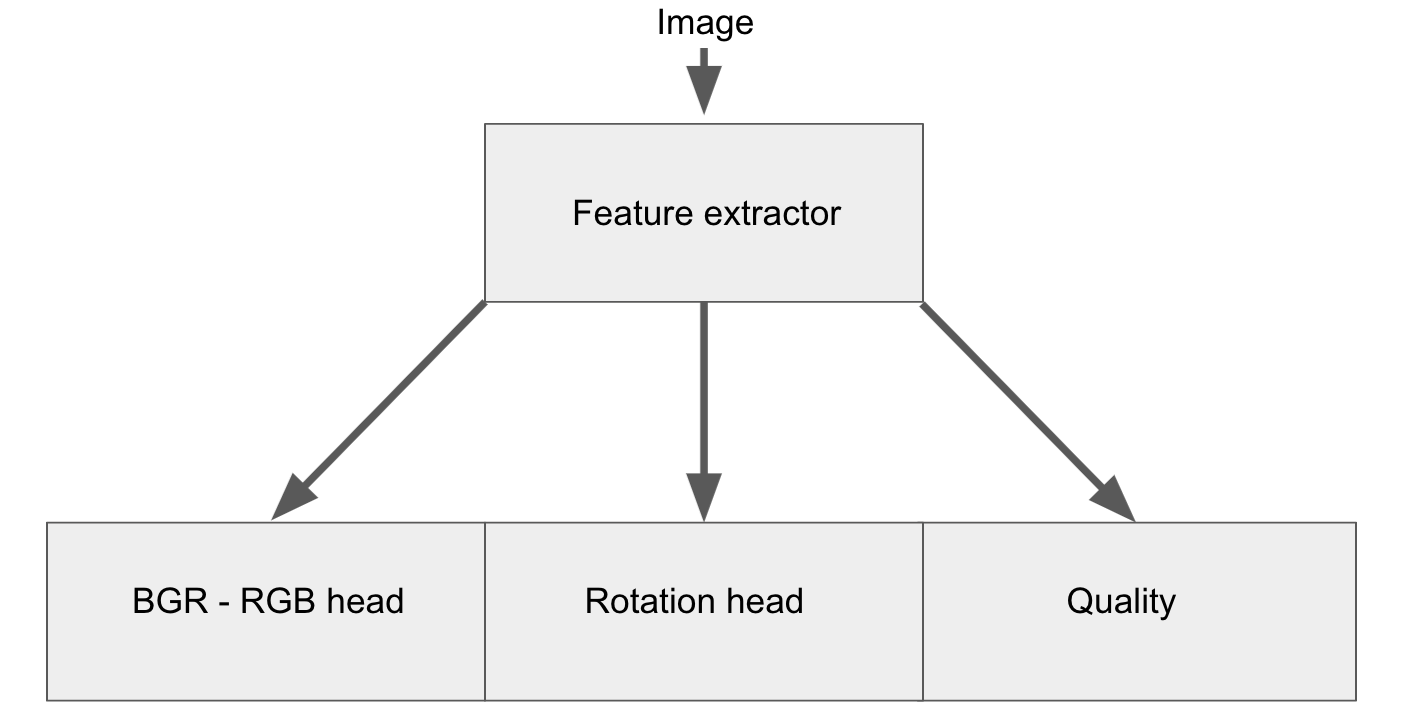

## Project Methodology

As an input, the model takes an image; as an output, there should be probabilities calculated for the next classes:

### Output - *quality*: 

**classes**: 

1. Blur - *image is blurred*

2. Torch -  *image is overexposed*

3. Sharp - *image is sharp and clean*

### Output - *rotation*:

**classes**: 

1. No rotation 0 degrees.

2. Сlockwise rotation for 90 degrees.

3. Counterclockwise rotation for 90 degrees.

4. Flipped image for 180 degrees.


### Output  RGB-BGR:

**classes**:

1. RGB

2. BGR

## Tips to mention

1. Write your own solution, do not use prettrained ones.
2. Use some of the Python libraries which you are most comfortable with - Pytorch, FastAI, Keras, Tensorflow.


## Data load from Kaggle

https://www.kaggle.com/kwentar/blur-dataset

In [6]:
!pip install -qq kaggle
!pip install -qq ipyplot
!pip install -qq Pillow

In [7]:
! mkdir -p /content/y_bezginova_blur_dataset

In [8]:
# set up kaggle json in colab and download the dataset
# make sure you downloaded kaggle.json locally from kaggle profile https://www.kaggle.com/ybezginova

import os
from google.colab import files

if not os.path.exists("/root/.kaggle/kaggle.json"):
  files.upload()
  ! mkdir -p ~/.kaggle
  ! mv kaggle.json ~/.kaggle/ 
  ! chmod 600 ~/.kaggle/kaggle.json

# upload file .json from kaggle profile https://www.kaggle.com/ybezginova pressong the button below

Saving kaggle.json to kaggle.json


In [9]:
# Remove the existing file or directory
!rm -rf blur-dataset.zip
!rm -rf ./blur-dataset

# Download the dataset again
!kaggle datasets download -d kwentar/blur-dataset
!unzip -qq blur-dataset.zip -d ./

100% 1.49G/1.49G [01:29<00:00, 18.7MB/s]
100% 1.49G/1.49G [01:29<00:00, 18.0MB/s]


In [3]:
import os
import cv2
import pandas as pd
import shutil
import random
import csv
import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from PIL import ImageEnhance
from keras.preprocessing.image import image_utils
from keras.preprocessing.image import ImageDataGenerator
from ipyplot import plot_images
from pylab import *
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix
import warnings

warnings.simplefilter("ignore")

# TensorFlow and Keras Layers
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau

print(cv2.version)


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        
<module 'cv2.version' from '/usr/local/lib/python3.8/dist-packages/cv2/version.py'>


## Writing all necessary functions

In [ ]:
CSV_PATH = '/content/labels.csv'
PATH = '/content'
NEW_FOLDER = '/content/y_bezginova_blur_dataset'
MOTION_BLURRED = 'motion_blurred'
DEFOCUSED_BLURRED = 'defocused_blurred'
SHARP = 'sharp'
IMAGE_WIDTH = 300
IMAGE_HEIGHT = 300

In [ ]:
class ImageInfo:
    def __init__(self, full_path: str):
        self.image_name: str = os.path.basename(full_path)
        self.full_path: str = full_path
        self.root_path: str = os.path.dirname(full_path)
        self.image: Image = None

In [ ]:
def load_images(root, image_folder, width, height):
    images = []
    full_path = os.path.join(root, image_folder)
    images_path_list = [os.path.join(full_path, f) for f in os.listdir(full_path) if
                        os.path.isfile(os.path.join(full_path, f))]
    for image_path in images_path_list:
        img_pil = image_utils.load_img(image_path, target_size=(width, height))
        image_info = ImageInfo(image_path)
        image_info.image = img_pil
        images.append(image_info)
    return images

In [ ]:
def rotate_images(images, angle: int):
    rotated_images = []
    for image_info in images:
        rotated_image_pil = image_info.image.copy().rotate(angle)
        rotated_image = ImageInfo(image_info.full_path)
        rotated_image.image = rotated_image_pil
        rotated_images.append(rotated_image)
    return rotated_images

In [ ]:
def brightness_pil(img: Image, factor=1):
    """by default factor = 1"""
    enhancer = ImageEnhance.Brightness(img)
    enhancer.enhance(factor)
    return enhancer.image

def add_brightness(images, factor=1):
    brightness_images = []
    for image in images:
        image_pil = brightness_pil(image.image.copy(), factor)
        image_bright = ImageInfo(image.full_path)
        image_bright.image = image_pil
        brightness_images.append(image_bright)
    return brightness_images

In [ ]:
def convert_to_bgr(images):
    bgr_images = []
    for image in images:
        bgr_mode_image = ImageInfo(image.full_path)
        bgr_mode_image.image = cv2.cvtColor(np.array(image.image), cv2.COLOR_RGB2BGR)
        bgr_images.append(bgr_mode_image)
    return bgr_images

In [ ]:
def save_images(images, root_path, prefix_name='', save_as_bgr=False):
    for image in images:
        if save_as_bgr:
            path = os.path.join(root_path, prefix_name + image.image_name)
            cv2.imwrite(path, image.image)
        else:
            image.image.save(os.path.join(root_path, prefix_name + image.image_name))

## 2) Using the inialized functions above, labeling the classes according to the task:
- sharp
- blur
- torch

- rotate_0
- rotate_90
- rotate_anti_90
- rotate_180

- rgb
- bgr


In [ ]:
images_motion_blured = load_images(PATH, MOTION_BLURRED, IMAGE_WIDTH, IMAGE_HEIGHT)

In [ ]:
images_defocused_blured = load_images(PATH, DEFOCUSED_BLURRED, IMAGE_WIDTH, IMAGE_HEIGHT)

In [ ]:
images_sharp = load_images(PATH, SHARP, IMAGE_WIDTH, IMAGE_HEIGHT)

In [ ]:
type(images_sharp)

list

In [ ]:
images_sharp_anti_90 = rotate_images(images_sharp, -90)
images_sharp_90 = rotate_images(images_sharp, 90)
images_sharp_180 = rotate_images(images_sharp, 180)

In [ ]:
image_brightness = add_brightness(images_sharp, 7.0)

In [ ]:
image_bgr = convert_to_bgr(images_sharp)

In [ ]:
print(len(images_sharp_anti_90))
print(len(images_sharp_90))
print(len(images_sharp_180))
print(len(images_sharp))
print(len(image_brightness))
print(len(images_motion_blured))
print(len(images_defocused_blured))
print(len(image_bgr))

350
350
350
350
350
350
350
350


In [ ]:
save_images(images_sharp_anti_90, NEW_FOLDER, 'anti_90_')
save_images(images_sharp_90, NEW_FOLDER, '90_')
save_images(images_sharp_180, NEW_FOLDER, '180_')
save_images(images_sharp, NEW_FOLDER)
save_images(image_brightness, NEW_FOLDER, 'torch_')
save_images(images_motion_blured, NEW_FOLDER)
save_images(images_defocused_blured, NEW_FOLDER)
save_images(image_bgr, NEW_FOLDER, 'bgr_', True)

### Кодирование данных

In [ ]:
df_map_v2 = {
    'image': [],
    'quality': [],
    'rotate': [],
    'mode': []
}

In [ ]:
def fill_map_v2(df_map, images, quality, rotate, mode):
    for image in images:
        df_map['image'].append(image.image_name)
        df_map['quality'].append(quality)
        df_map['rotate'].append(rotate)
        df_map['mode'].append(mode)

In [ ]:
# labeling the data
fill_map_v2(df_map_v2, images_sharp, 'sharp', 'rotate_0', 'rgb')
fill_map_v2(df_map_v2, images_motion_blured, 'blur', 'rotate_0', 'rgb')
fill_map_v2(df_map_v2, images_defocused_blured, 'blur', 'rotate_0', 'rgb')
fill_map_v2(df_map_v2, image_brightness, 'torch', 'rotate_0', 'rgb')
fill_map_v2(df_map_v2, images_sharp_90, 'sharp', 'rotate_90', 'rgb')
fill_map_v2(df_map_v2, images_sharp_anti_90, 'sharp', 'rotate_anti_90', 'rgb')
fill_map_v2(df_map_v2, images_sharp_180, 'sharp', 'rotate_180', 'rgb')
fill_map_v2(df_map_v2, image_bgr, 'sharp', 'rotate_0', 'bgr')

In [ ]:
d = pd.DataFrame(df_map_v2)
d.head(20)

,image,quality,rotate,mode
0,314_IPHONE-5S_S.jpeg,sharp,rotate_0,rgb
1,129_NIKON-D3400-18-55MM_S.JPG,sharp,rotate_0,rgb
2,28_HONOR-8X_S.jpg,sharp,rotate_0,rgb
3,226_IPHONE-7-PLUS_S.jpeg,sharp,rotate_0,rgb
4,326_XIAOMI-PROCOFONE-F1_S.jpg,sharp,rotate_0,rgb
5,34_HONOR-8X_S.jpg,sharp,rotate_0,rgb
6,267_SONY-NEX-5T_S.JPG,sharp,rotate_0,rgb
7,88_HONOR-8X_S.jpg,sharp,rotate_0,rgb
8,281_NIKON-D3400-18-55MM_S.JPG,sharp,rotate_0,rgb
9,291_IPHONE-SE_S.jpg,sharp,rotate_0,rgb


In [ ]:
d['quality'].value_counts()

sharp    1750
blur      700
torch     350
Name: quality, dtype: int64

In [ ]:
d['rotate'].value_counts()

rotate_0          1750
rotate_90          350
rotate_anti_90     350
rotate_180         350
Name: rotate, dtype: int64

In [ ]:
d['mode'].value_counts()

rgb    2450
bgr     350
Name: mode, dtype: int64

In [ ]:
d.head(7)

,image,quality,rotate,mode
0,314_IPHONE-5S_S.jpeg,sharp,rotate_0,rgb
1,129_NIKON-D3400-18-55MM_S.JPG,sharp,rotate_0,rgb
2,28_HONOR-8X_S.jpg,sharp,rotate_0,rgb
3,226_IPHONE-7-PLUS_S.jpeg,sharp,rotate_0,rgb
4,326_XIAOMI-PROCOFONE-F1_S.jpg,sharp,rotate_0,rgb
5,34_HONOR-8X_S.jpg,sharp,rotate_0,rgb
6,267_SONY-NEX-5T_S.JPG,sharp,rotate_0,rgb


## Preparing the dataset for work
The code goes through each class folder in the train_dir and splits the files into training, validation, and testing sets using the train_test_split function from sklearn.model_selection. Then, the validation and testing sets are moved to the corresponding directories using the shutil.move function.

In [ ]:
# проверка на пропуски
pd.DataFrame(round(d.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
image,0.000000
quality,0.000000
rotate,0.000000
mode,0.000000


In [ ]:
len(d)

2800

### Reviewing the received dataset

Number of quality classes: 3
Quality classes: ['blur' 'sharp' 'torch']

Number of rotate classes: 4
Rotate classes: ['rotate_0' 'rotate_180' 'rotate_90' 'rotate_anti_90']

Number of mode classes: 2
Mode classes: ['bgr' 'rgb']



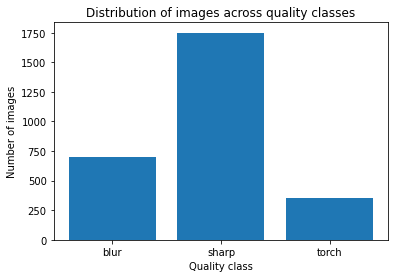

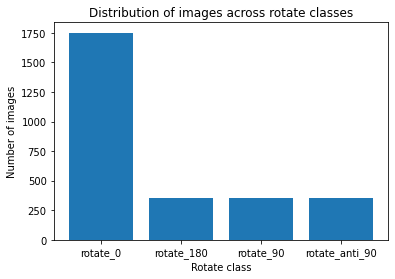

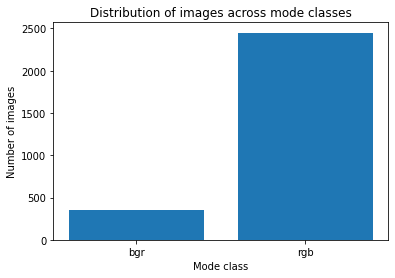

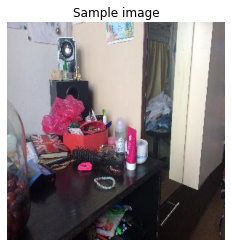

Shape of the sample image: (300, 300, 3)


In [ ]:
# Get the number of classes for each output
quality_classes = np.unique(d['quality'])
num_quality_classes = len(quality_classes)

rotate_classes = np.unique(d['rotate'])
num_rotate_classes = len(rotate_classes)

mode_classes = np.unique(d['mode'])
num_mode_classes = len(mode_classes)

# Print the number of classes for each output
print("Number of quality classes:", num_quality_classes)
print("Quality classes:", quality_classes)
print()
print("Number of rotate classes:", num_rotate_classes)
print("Rotate classes:", rotate_classes)
print()
print("Number of mode classes:", num_mode_classes)
print("Mode classes:", mode_classes)
print()
# Get the number of images for each class of each output
num_quality_images = []
for c in quality_classes:
    num_quality_images.append(len(d[d['quality'] == c]))

num_rotate_images = []
for c in rotate_classes:
    num_rotate_images.append(len(d[d['rotate'] == c]))

num_mode_images = []
for c in mode_classes:
    num_mode_images.append(len(d[d['mode'] == c]))

# Plot histograms of the number of images for each class of each output
plt.bar(quality_classes, num_quality_images)
plt.xlabel('Quality class')
plt.ylabel('Number of images')
plt.title('Distribution of images across quality classes')
plt.show()

plt.bar(rotate_classes, num_rotate_images)
plt.xlabel('Rotate class')
plt.ylabel('Number of images')
plt.title('Distribution of images across rotate classes')
plt.show()

plt.bar(mode_classes, num_mode_images)
plt.xlabel('Mode class')
plt.ylabel('Number of images')
plt.title('Distribution of images across mode classes')
plt.show()

# Load and display a sample image
img_path = os.path.join('/content/y_bezginova_blur_dataset', d.iloc[0]['image'])
img = plt.imread(img_path)

# Display the sample image
plt.imshow(img)
plt.axis('off')
plt.title('Sample image')
plt.show()

# Print the shape of the sample image
print("Shape of the sample image:", img.shape)


### Dataset and class description for training
- Output 1 'quality' contains 3 classes: ['blur', 'sharp', 'torch']
- Output 2 'rotate' contains 4 classes: ['rotate_0', 'rotate_180', 'rotate_90', 'rotate_anti_90']
- Output 3 'mode' contains 2 classes: ['bgr', 'rgb']

#### The 'quality' class is imbalanced - sharp images dominate. The histograms of the 'rotate' class show that there are more images without rotation, which is a risk of under-training the network. The ['bgr', 'rgb'] class is also imbalanced. In general, class imbalance is an issue that should be addressed, especially if the sample is small.

## Formation of samples for training, validation, and model testing
- train - 70%
- validation - 10%
- test - 20%

In [ ]:
train_datagen = ImageDataGenerator(
    validation_split=0.10,
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2
)

val_datagen = ImageDataGenerator(
    validation_split=0.10,
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    validation_split=0.20,
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2
)

# Set the batch size
BATCH_SIZE = 32
TARGET_WIDTH = 200
TARGET_HEIGHT = 200
cols = ['quality', 'rotate', 'mode']

In [ ]:
# Create the train, validation, and test generators
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=d,  # labels
    directory='/content/y_bezginova_blur_dataset/',
    target_size=(TARGET_WIDTH, TARGET_HEIGHT),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode="multi_output",
    seed=12345,
    x_col='image',
    y_col=cols
)

val_datagen_flow = val_datagen.flow_from_dataframe(
    dataframe=d,  # labels
    directory='/content/y_bezginova_blur_dataset/',
    target_size=(TARGET_WIDTH, TARGET_HEIGHT),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode="multi_output",
    seed=12345,
    x_col='image',
     y_col=cols
)

test_datagen_flow = test_datagen.flow_from_dataframe(
    dataframe=d,     # labels
    directory='/content/y_bezginova_blur_dataset/',
    target_size=(TARGET_WIDTH, TARGET_HEIGHT),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode="multi_output",
    seed=12345,
    x_col='image',
    y_col=cols
)

Found 2520 validated image filenames.
Found 280 validated image filenames.
Found 560 validated image filenames.


In [ ]:
print(next(train_datagen_flow)[0][0])

[[[0.6623689  0.5525649  0.39962375]
  [0.6826098  0.5728059  0.41986468]
  [0.68602854 0.5762246  0.42328346]
  ...
  [0.227451   0.3019608  0.1764706 ]
  [0.227451   0.3019608  0.1764706 ]
  [0.227451   0.3019608  0.1764706 ]]

 [[0.66256326 0.55275935 0.3998182 ]
  [0.68348473 0.57368076 0.4207396 ]
  [0.68515366 0.57534975 0.42240855]
  ...
  [0.227451   0.3019608  0.1764706 ]
  [0.227451   0.3019608  0.1764706 ]
  [0.227451   0.3019608  0.1764706 ]]

 [[0.66275775 0.55295384 0.4000126 ]
  [0.68435967 0.57455575 0.42161453]
  [0.6842788  0.5744748  0.4215336 ]
  ...
  [0.227451   0.3019608  0.1764706 ]
  [0.227451   0.3019608  0.1764706 ]
  [0.227451   0.3019608  0.1764706 ]]

 ...

 [[0.3385175  0.2365567  0.13851747]
  [0.33411378 0.23215298 0.13674296]
  [0.35289073 0.25092992 0.16073385]
  ...
  [0.7705843  0.78627056 0.782349  ]
  [0.7706815  0.7863678  0.7824462 ]
  [0.7707787  0.786465   0.7825434 ]]

 [[0.34343216 0.24339904 0.14439598]
  [0.3499188  0.24795805 0.15274243]


## Model
Write your model and data visualization here. The architecture can be anything at your discretion (CNN, Transformers, SE blocks). Use the necessary metrics and confusion matrix for model analysis.

Test the model on test data.

### Building a CNN with three outputs.

In [ ]:
type(train_datagen)

keras.preprocessing.image.ImageDataGenerator

In [ ]:
type(train_datagen_flow)

keras.preprocessing.image.DataFrameIterator

In [ ]:
# Split the dataframe into training and testing sets
train_df, test_df = train_test_split(d, test_size=0.2, random_state=5)

# Split the training set further into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=5)

print('Размер обучающей выборки:', train_df.shape[0])
print('Размер валидационной выборки:', val_df.shape[0])
print('Размер тестовой выборки:', test_df.shape[0])

Размер обучающей выборки: 2016
Размер валидационной выборки: 224
Размер тестовой выборки: 560


In [ ]:
# Define input shape
INPUT_SHAPE = (150, 150, 3)

STEP_SIZE_TRAIN=train_datagen_flow.n//train_datagen_flow.batch_size
STEP_SIZE_VALID=val_datagen_flow.n//val_datagen_flow.batch_size

In [4]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import Sequence
import tensorflow as tf

In [ ]:
# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax', name='quality'), # 3 classes for output1
    tf.keras.layers.Dense(4, activation='softmax', name='rotate'), # 4 classes for output2
    tf.keras.layers.Dense(2, activation='softmax', name='mode')  # 2 classes for output3
])

# Compile the model
optimizer = Adam(learning_rate=0.0001) # updated to lr=0.0001

model.compile(optimizer=optimizer,
              loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'],
              metrics=['accuracy'])

# Convert the string labels to integers using LabelEncoder
le = LabelEncoder()

# Convert the actual output labels to one-hot encoded vectors
# train_quality_labels = train_df['quality'].values
train_quality_labels = le.fit_transform(train_df['quality'].values)
# train_rotate_labels = train_df['rotate'].values
train_rotate_labels = le.fit_transform(train_df['rotate'].values)
train_mode_labels = le.fit_transform(train_df['mode'].values)

# val_quality_labels = val_df['quality'].values
val_quality_labels = le.fit_transform(val_df['quality'].values)
# val_rotate_labels = val_df['rotate'].values
val_rotate_labels = le.fit_transform(val_df['rotate'].values)
# val_mode_labels = val_df['mode'].values
val_mode_labels = le.fit_transform(val_df['mode'].values)

# test_quality_labels = test_df['quality'].values
test_quality_labels = le.fit_transform(test_df['quality'].values)
# test_rotate_labels = test_df['rotate'].values
test_rotate_labels = le.fit_transform(test_df['rotate'].values)
# test_mode_labels = test_df['mode'].values
test_mode_labels = le.fit_transform(test_df['mode'].values)

# One-hot encode the actual training and validation labels for the mode output
train_quality = to_categorical(train_quality_labels, num_classes=3)
train_rotate = to_categorical(train_rotate_labels, num_classes=4)
train_mode = to_categorical(train_mode_labels, num_classes=2)

val_quality = to_categorical(val_quality_labels, num_classes=3)
val_rotate = to_categorical(val_rotate_labels, num_classes=4)
val_mode = to_categorical(val_mode_labels, num_classes=2)

test_quality = to_categorical(test_quality_labels, num_classes=3)
test_rotate = to_categorical(test_rotate_labels, num_classes=4)
test_mode = to_categorical(test_mode_labels, num_classes=2)

NameError: ignored

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, dataframe, batch_size, shuffle=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_data = self.dataframe[idx * self.batch_size : (idx + 1) * self.batch_size]
        X, y_quality, y_rotate, y_mode = self.__data_generation(batch_data)
        return X, [y_quality, y_rotate, y_mode]

    def __data_generation(self, batch_data):
        X = np.empty((self.batch_size, *INPUT_SHAPE))
        y_quality = np.empty((self.batch_size, 3), dtype=int)
        y_rotate = np.empty((self.batch_size, 4), dtype=int)
        y_mode = np.empty((self.batch_size, 2), dtype=int)
        for i, ID in enumerate(batch_data['ID']):
            # Load the input image
            X[i,] = np.load(f'path/to/{ID}.npy')

            # Get the target data
            y_quality[i,] = train_quality[train_df.index[train_df['ID'] == ID].tolist()[0]]
            y_rotate[i,] = train_rotate[train_df.index[train_df['ID'] == ID].tolist()[0]]
            y_mode[i,] = train_mode[train_df.index[train_df['ID'] == ID].tolist()[0]]

        return X, y_quality, y_rotate, y_mode


In [ ]:
print(np.shape(val_datagen_flow))
print(np.shape(val_quality), np.shape(val_rotate), np.shape(val_mode))

In [ ]:
val_datagen_flow_data = next(val_datagen_flow)
print(np.shape(val_datagen_flow_data[0]))

In [ ]:
history = model.fit_generator(train_datagen_flow, 
          epochs=30, 
          validation_steps=STEP_SIZE_TRAIN,
          steps_per_epoch=STEP_SIZE_VALID,
          validation_data = ([val_datagen_flow], [val_quality, val_rotate, val_mode]))

In [ ]:
# Evaluating the model
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN #1 Performance (30 epochs)', fontsize=10)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0, 30))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, mohistorydel.history['val_accuracy'], label='Validation Accuracy')

ax1.set_xticks(np.arange(0, 30, 7))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 30, 7))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### For one output, we will build SE blocks.

In [ ]:
# overexposing our image

def adjust_gamma(image, gamma=1):
    # build a lookup table mapping the pixel values [0, 255] to their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i/255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype('uint8')

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

# creating directories to save blurred and overexposed images

parent_dir = '/content/y_bezginova_blur_dataset/'

directory1 = 'blurred'
path_blur = os.path.join(parent_dir, directory1)
os.mkdir(path_blur)

directory2 = 'overexposed'
path_overexposed = os.path.join(parent_dir, directory2)
os.mkdir(path_overexposed)

In [ ]:
import glob

path = "/content/y_bezginova_blur_dataset/sharp/*"
i = 1
for file in glob.glob(path):
    #print(file)
    image_read = cv2.imread(file, 1)

    # conversion numpy array into rgb image to show
    img = cv2.cvtColor(image_read, cv2.COLOR_BGR2RGB)

    # blurring and overexposing intensity
    gamma_choice = random.randint(1,6)
    blur_choice = random.choice([8,10,12,14,16])

    gamma_img = adjust_gamma(img, gamma_choice)

    # blurring images
    avg_blur = cv2.blur(img, (blur_choice, blur_choice))

    cv2.imwrite(os.path.join(path_blur,f'{i}.jpg'), avg_blur)
    cv2.imwrite(os.path.join(path_overexposed, f'{i}.jpg'), gamma_img)

    i+=1    

In [ ]:
# run this only when you have to rename images in the sub-folders

dataset_dir = '/content/y_bezginova_blur_dataset/'

for folder in os.listdir(dataset_dir):
    print(folder)
    for i, filename in enumerate(os.listdir(dataset_dir+folder)):
        #print(filename)
        os.rename(dataset_dir+folder+'/'+filename, dataset_dir+folder+'/'+folder+'_'+str(i)+'.jpg')

In [ ]:
# Data Preparation

categories = ['blurred', 'overexposed','sharp']
training = []
IMG_SIZE = 200

def create_training_data():
    for category in categories:
        path = dataset_dir+category
        print(path)
        class_num = categories.index(category)

        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training.append([img_array, class_num])

create_training_data()

In [ ]:
# Data Preprocessing

# shuffling the dataset
random.shuffle(training)

# assigning labels and features

X = []
y = []
for features, label in training:
    X.append(features)
    y.append(label)

# resizing features in accordance with CNN
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# Normalising X and converting labels to categorical features
X = X.astype('float32')
X /= 255

y = np_utils.to_categorical(y,3)

# splitting X and y for use in CNN
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

### Model - SE blocks

In [ ]:
# data augmentation

datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.1
)

datagen.fit(X_train)

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
def SE_block(inputs, ratio=8):
     b, h, w, c = inputs.shape

     # squeeze 
     x = GlobalAveragePooling2D()(inputs)
     x = Reshape((1, 1, c))(x)
     # extraction
     x = Dense(c//ratio, activation='relu', kernel_initializer='glorot_uniform', use_bias=False)(x)
     x = Dense(c, activation='sigmoid', kernel_initializer='glorot_uniform', use_bias=False)(x)

     # scaling
     x = Multiply()([inputs, x]) # x*inputs

     return x

# its returns tensor with original input shape

inputs = Input(shape=(128, 128, 32))
print(SE_block(inputs).shape)

def create_model():

    input_tensor = Input(shape=[IMG_SIZE, IMG_SIZE, 3])
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same',
               activation='relu')(input_tensor)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = SE_block(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same',activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = SE_block(x)

    # fully connected
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    output_tensor = Dense(3, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=output_tensor)

    # compiling our model
    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    model.summary()
    
    return model

# fittin the model

model = create_model()
epochs = 30
batch_size = 32

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                              epochs=epochs, validation_data=(X_test, y_test),
                              steps_per_epoch=X_train.shape[0]//batch_size,
                              callbacks=[learning_rate_reduction])

In [ ]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Plot the loss and accuracy curves for training and validation

plt.subplot(1,2,1) 
plt.plot(history.history['loss'], color='b', label='Training Loss')
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2) 
plt.plot(history.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='r', label="validation accuracy")
plt.title("Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Acc")
plt.legend()

plt.show()

In [ ]:
##################################################### NEW CNN ####################################################

In [ ]:
import os
from typing import List, Dict

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras import Sequential, optimizers, losses, metrics
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.preprocessing.image import image_utils, ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [ ]:
def read_images_cv2(path, width: int, height: int, bgr_mode=False):
    images_list = []
    images_path_list = [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    for image_path in images_path_list:
        image = cv2.imread(image_path, )
        if not bgr_mode:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (width, height), interpolation=cv2.INTER_NEAREST)
        image = image_utils.img_to_array(image)
        image /= 255.0
        images_list.append(image)
    print(f'loaded size: {len(images_list)}')
    return images_list

In [ ]:
def rotate_images_cv(images, cv_code):
    rotated_images_list = []
    for image in images:
        rotated_image = cv2.rotate(image, cv_code)
        rotated_images_list.append(rotated_image)
    return rotated_images_list

In [ ]:
def convert_to_bgr_images(images):
    rgb_images_list = []
    for image in images:
        rgb_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        rgb_images_list.append(rgb_image)
    return rgb_images_list

In [ ]:
def brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [ ]:
def add_brightness(images, value=30):
    brightness_images = []
    for image in images:
        img = brightness(image, value)
        brightness_images.append(img)
    return brightness_images

In [ ]:
def fill_map(df_map: Dict[str, List], images, key, value):
    if key not in df_map:
        df_map[key] = []
    for image in images:
        df_map['image'].append(image_utils.img_to_array(image))
        df_map[key].append(value)

In [ ]:
def plot_accuracies(history, loss_key, accuracy_key):
    plt.plot(history.history[accuracy_key])
    plt.plot(history.history[loss_key])
    plt.title(f'model accuracy for {accuracy_key}')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'loss'], loc='upper left')
    plt.show()

In [ ]:
def plot_confusion_matrix(matrix, name):
    ax = sns.heatmap(matrix, annot=True, cmap='Blues')

    ax.set_title(f'Matrix {name} \n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    #ax.xaxis.set_ticklabels(['False', 'True'])
    #ax.yaxis.set_ticklabels(['False', 'True'])

    plt.show()

In [ ]:
ROOT_PATH = '/content'
SHARP_PATH = 'sharp'
MOTION_BLURRED = 'motion_blurred'
DEFOCUSED_BLURRED = 'defocused_blurred'
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64

In [ ]:
images_sharp = read_images_cv2(os.path.join(ROOT_PATH, SHARP_PATH), IMAGE_WIDTH, IMAGE_HEIGHT)

loaded size: 350


In [ ]:
images_motion_blurred = read_images_cv2(os.path.join(ROOT_PATH, MOTION_BLURRED), IMAGE_WIDTH, IMAGE_HEIGHT)

loaded size: 350


In [ ]:
images_defocused_blurred = read_images_cv2(os.path.join(ROOT_PATH, DEFOCUSED_BLURRED), IMAGE_WIDTH, IMAGE_HEIGHT)

loaded size: 350


In [ ]:
images_sharp_rotate_90 = rotate_images_cv(images_sharp, cv2.ROTATE_90_CLOCKWISE)
images_sharp_rotate_anti_90 = rotate_images_cv(images_sharp, cv2.ROTATE_90_COUNTERCLOCKWISE)
images_sharp_rotate_180 = rotate_images_cv(images_sharp, cv2.ROTATE_180)

In [ ]:
images_brightness = add_brightness(images_sharp, 40)

In [ ]:
images_bgr = convert_to_bgr_images(images_sharp)

In [ ]:
###### QUALITY #########

In [ ]:
df_map_quality = {
    'image': [],
    'quality': []
}
fill_map(df_map_quality, images_sharp[:116], 'quality', 'sharp')
fill_map(df_map_quality, images_motion_blurred[117:234], 'quality', 'blur')
fill_map(df_map_quality, images_brightness[:117], 'quality', 'torch')

In [ ]:
df_quality = pd.DataFrame(df_map_quality)
df_quality.shape

(350, 2)

In [ ]:
ohe_quality = OneHotEncoder()

X_quality = df_quality['image']
y_quality = ohe_quality.fit_transform(df_quality[['quality']].values)
y_quality = y_quality.toarray()
print(f'X: {X_quality.shape}')
print(f'y: {y_quality.shape}')
print(f'categories: {ohe_quality.categories_}')

X: (350,)
y: (350, 3)
categories [array(['blur', 'sharp', 'torch'], dtype=object)]


In [ ]:
X_train_quality, X_test_quality, y_train_quality, y_test_quality = train_test_split(
    np.array([np.array(val) for val in X_quality.values]), y_quality, test_size=0.33, random_state=42)
print(f'train size {X_train_quality.shape}')
print(f'train size {y_train_quality.shape}')

train size (234, 64, 64, 3)
train size (234, 3)


In [ ]:
####### ROTATION ###############

In [ ]:
df_map_rotation = {
    'image': [],
    'rotate': []
}
fill_map(df_map_rotation, images_sharp[:87], 'rotate', 'rotate_none')
fill_map(df_map_rotation, images_sharp_rotate_90[87:174], 'rotate', 'rotate_90')
fill_map(df_map_rotation, images_sharp_rotate_anti_90[174:261], 'rotate', 'rotate_anti_90')
fill_map(df_map_rotation, images_sharp_rotate_180[261:], 'rotate', 'rotate_180')

In [ ]:
df_rotate = pd.DataFrame(df_map_rotation)
df_rotate.shape

(350, 2)

In [ ]:
ohe_rotate = OneHotEncoder()

X_rotate = df_rotate['image']
y_rotate = ohe_rotate.fit_transform(df_rotate[['rotate']].values)
y_rotate = y_rotate.toarray()
print(f'X: {X_rotate.shape}')
print(f'y: {y_rotate.shape}')
print(f'categories: {ohe_rotate.categories_}')

X: (350,)
y: (350, 4)
categories: [array(['rotate_180', 'rotate_90', 'rotate_anti_90', 'rotate_none'],
      dtype=object)]


In [ ]:
X_train_rotate, X_test_rotate, y_train_rotate, y_test_rotate = train_test_split(
    np.array([np.array(val) for val in X_rotate.values]), y_rotate, test_size=0.33, random_state=42)

In [ ]:
########## RGB-BGR MODE #########

In [ ]:
df_map_mode = {
    'image': [],
    'mode': []
}
fill_map(df_map_mode, images_sharp[:175], 'mode', 'rgb')
fill_map(df_map_mode, images_bgr[175:], 'mode', 'bgr')

In [ ]:
df_mode = pd.DataFrame(df_map_mode)
df_mode.shape

(350, 2)

In [ ]:
ohe_mode = OneHotEncoder()

X_mode = df_mode['image']
y_mode = ohe_mode.fit_transform(df_mode[['mode']].values)
y_mode = y_mode.toarray()
print(f'X: {X_mode.shape}')
print(f'y: {y_mode.shape}')
print(f'categories: {ohe_mode.categories_}')

X: (350,)
y: (350, 2)
categories: [array(['bgr', 'rgb'], dtype=object)]


In [ ]:
X_train_mode, X_test_mode, y_train_mode, y_test_mode = train_test_split(
    np.array([np.array(val) for val in X_mode.values]), y_mode, test_size=0.33, random_state=42)

In [ ]:
from keras import Input


def get_model_func(input_name):
    input = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), name=input_name)
    model = Conv2D(16, (3, 3), padding='same', activation='relu')(input)
    model = Conv2D(32, (3, 3), activation='relu', padding='same')(model)
    model = Conv2D(32, (3, 3), activation='relu', padding='same')(model)
    model = MaxPooling2D(pool_size=(2, 2))(model)
    model = Dropout(0.25)(model)
    model = Conv2D(64, (3, 3), padding='same', activation='relu')(model)
    model = Conv2D(64, (3, 3), activation='relu', padding='same')(model)
    model = Conv2D(64, (3, 3), activation='relu', padding='same')(model)
    model = MaxPooling2D(pool_size=(2, 2))(model)
    model = Dropout(0.25)(model)
    model = Flatten()(model)
    out = Dense(256, activation='relu')(model)
    return Model(inputs=[input], outputs=[out])

In [ ]:
###### BUILD CNN ###########

In [ ]:
from keras.models import Model
from keras.layers import concatenate

model_quality = get_model_func('input1')
model_rotate = get_model_func('input2')
model_mode = get_model_func('input3')

mergedOutput = concatenate([model_quality.output, model_rotate.output, model_mode.output])
out_quality = Dense(3, activation='softmax', name='quality')(mergedOutput)
out_rotate = Dense(4, activation='softmax', name='rotate')(mergedOutput)
out_mode = Dense(2, activation='softmax', name='mode')(mergedOutput)

merged_model = Model(inputs=[model_quality.input, model_rotate.input, model_mode.input],
                     outputs=[out_quality, out_rotate, out_mode])

In [ ]:
#merged_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 input2 (InputLayer)            [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 input3 (InputLayer)            [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   448         ['input1[0][0]']                 
                                                                                            

In [ ]:
merged_model.compile(optimizers.Adam(learning_rate=0.0001, decay=1e-6),
                     loss='categorical_crossentropy',
                     metrics="categorical_accuracy")

In [ ]:
history = merged_model.fit(x={'input1': X_train_quality, 'input2': X_train_rotate, 'input3': X_train_mode},
                 y={'quality': y_train_quality, 'rotate': y_train_rotate, 'mode': y_train_mode},
                 batch_size=100, epochs=40)

Epoch 1/40
3/3 [==============================] - 2s 111ms/step - loss: 4.5070 - quality_loss: 1.3544 - rotate_loss: 2.3671 - mode_loss: 0.7854 - quality_categorical_accuracy: 0.3120 - rotate_categorical_accuracy: 0.2821 - mode_categorical_accuracy: 0.4744
Epoch 2/40
3/3 [==============================] - 0s 111ms/step - loss: 2.6610 - quality_loss: 0.7461 - rotate_loss: 1.4452 - mode_loss: 0.4697 - quality_categorical_accuracy: 0.6111 - rotate_categorical_accuracy: 0.4316 - mode_categorical_accuracy: 0.6111
Epoch 3/40
3/3 [==============================] - 0s 111ms/step - loss: 2.3131 - quality_loss: 0.6638 - rotate_loss: 1.2294 - mode_loss: 0.4200 - quality_categorical_accuracy: 0.6453 - rotate_categorical_accuracy: 0.3547 - mode_categorical_accuracy: 0.8248
Epoch 4/40
3/3 [==============================] - 0s 110ms/step - loss: 2.1126 - quality_loss: 0.5770 - rotate_loss: 1.1443 - mode_loss: 0.3913 - quality_categorical_accuracy: 0.6453 - rotate_categorical_accuracy: 0.4231 - mode_c

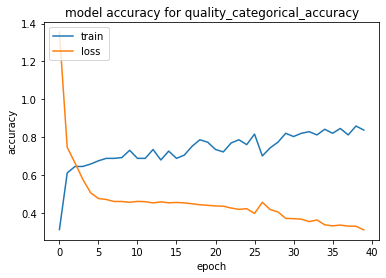

In [ ]:
plot_accuracies(history, 'quality_loss', 'quality_categorical_accuracy')

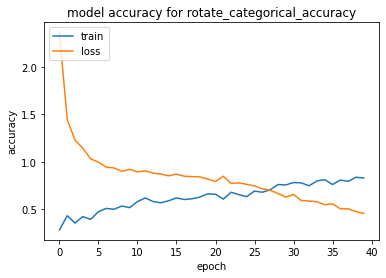

In [ ]:
plot_accuracies(history, 'rotate_loss', 'rotate_categorical_accuracy')

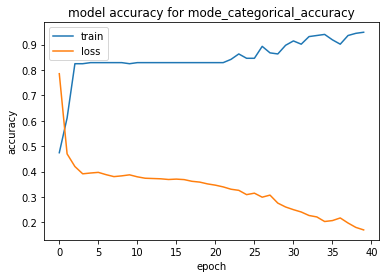

In [ ]:
plot_accuracies(history, 'mode_loss', 'mode_categorical_accuracy')

In [ ]:
############# CHECK MODEL PREDICTION ###################

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, auc, roc_auc_score

In [ ]:
predicts_merged_model = merged_model.predict([X_test_quality, X_test_rotate, X_test_mode])

4/4 [==============================] - 1s 87ms/step


In [ ]:
#QUALITY
accuracy_quality_score = accuracy_score(y_test_quality.argmax(axis=1), predicts_merged_model[0].argmax(axis=1))
roc_auc_quality_score = roc_auc_score(y_test_quality, predicts_merged_model[0])
f1_quality_score = f1_score(y_test_quality.argmax(axis=1), predicts_merged_model[0].argmax(axis=1), average='macro')
recall_quality_score = recall_score(y_test_quality.argmax(axis=1), predicts_merged_model[0].argmax(axis=1), average='macro')
precision_quality_score = precision_score(y_test_quality.argmax(axis=1), predicts_merged_model[0].argmax(axis=1), average='macro')
print(f'accuracy quality score: {accuracy_quality_score}')
print(f'roc-auc quality score: {roc_auc_quality_score}')
print(f'f1 quality score: {f1_quality_score}')
print(f'recall quality score: {recall_quality_score}')
print(f'precision quality score: {precision_quality_score}')
print('\n')

#ROTATE
accuracy_rotate_score = accuracy_score(y_test_rotate.argmax(axis=1), predicts_merged_model[1].argmax(axis=1))
roc_auc_rotate_score = roc_auc_score(y_test_rotate, predicts_merged_model[1])
f1_rotate_score = f1_score(y_test_rotate.argmax(axis=1), predicts_merged_model[1].argmax(axis=1), average='macro')
recall_rotate_score = recall_score(y_test_rotate.argmax(axis=1), predicts_merged_model[1].argmax(axis=1), average='macro')
precision_rotate_score = precision_score(y_test_rotate.argmax(axis=1), predicts_merged_model[1].argmax(axis=1), average='macro')
print(f'accuracy rotate score: {accuracy_rotate_score}')
print(f'roc-auc rotate score: {roc_auc_rotate_score}')
print(f'f1 rotate score: {f1_rotate_score}')
print(f'recall rotate score: {recall_rotate_score}')
print(f'precision rotate score: {precision_rotate_score}')
print('\n')

#MODE
accuracy_mode_score = accuracy_score(y_test_mode.argmax(axis=1), predicts_merged_model[2].argmax(axis=1))
roc_auc_mode_score = roc_auc_score(y_test_mode, predicts_merged_model[2])
f1_mode_score = f1_score(y_test_mode.argmax(axis=1), predicts_merged_model[2].argmax(axis=1), average='macro')
recall_mode_score = recall_score(y_test_mode.argmax(axis=1), predicts_merged_model[2].argmax(axis=1), average='macro')
precision_mode_score = precision_score(y_test_mode.argmax(axis=1), predicts_merged_model[2].argmax(axis=1), average='macro')
print(f'accuracy mode(RGB-BGR) score: {accuracy_mode_score}')
print(f'roc-auc mode(RGB-BGR) score: {roc_auc_mode_score}')
print(f'f1 mode(RGB-BGR) score: {f1_mode_score}')
print(f'recall rotate score: {recall_mode_score}')
print(f'precision rotate score: {precision_mode_score}')

accuracy quality score: 0.7672413793103449
roc-auc quality score: 0.90121085847217
f1 quality score: 0.7670988132377157


accuracy rotate score: 0.6551724137931034
roc-auc rotate score: 0.8787763656202783
f1 rotate score: 0.6533811475409836


accuracy mode(RGB-BGR) score: 0.9482758620689655
roc-auc mode(RGB-BGR) score: 0.9833482010110021
f1 mode(RGB-BGR) score: 0.9482604817127565


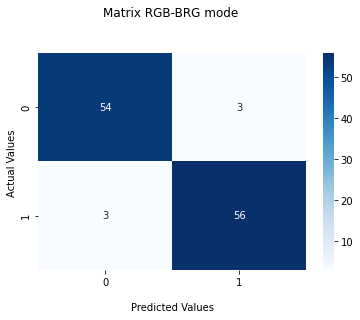

In [ ]:
#RGB-BGR
mode_cf_matrix = confusion_matrix(y_test_mode.argmax(axis=1), predicts_merged_model[2].argmax(axis=1))
plot_confusion_matrix(mode_cf_matrix, 'RGB-BRG mode')

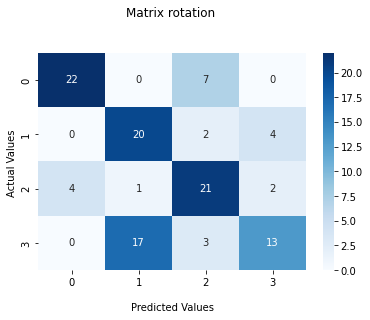

In [ ]:
#ROTATION
mode_cf_matrix_rotation = confusion_matrix(y_test_rotate.argmax(axis=1), predicts_merged_model[1].argmax(axis=1))
plot_confusion_matrix(mode_cf_matrix_rotation, 'rotation')

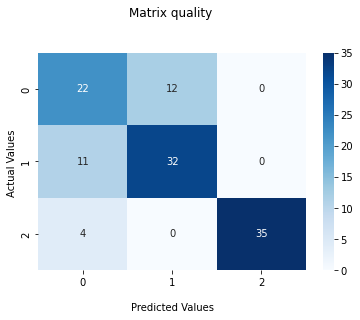

In [ ]:
#QUALITY
mode_cf_matrix_rotation = confusion_matrix(y_test_quality.argmax(axis=1), predicts_merged_model[0].argmax(axis=1))
plot_confusion_matrix(mode_cf_matrix_rotation, 'quality')